In this notebook we are trying to predict the Departure delay of the flights using machine learning models such as linear regression, random Forest regressor and decision tree regressor

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

spark = (SparkSession
.builder
.appName("ML-delay")
.getOrCreate()
)

In [0]:
import pandas
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [0]:
flight_file_path = "dbfs:/FileStore/shared_uploads/nsingh17@stevens.edu/Airlines Airports Cancellation Codes & Flights/flights.csv"
flights = spark.read.csv(flight_file_path, header=True, inferSchema=True)

In [0]:
data = flights.select('MONTH','DAY','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE','SCHEDULED_DEPARTURE','DEPARTURE_DELAY')
data.show()

+-----+---+-----------+-------+--------------+-------------------+--------+-------------------+---------------+
|MONTH|DAY|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DISTANCE|SCHEDULED_DEPARTURE|DEPARTURE_DELAY|
+-----+---+-----------+-------+--------------+-------------------+--------+-------------------+---------------+
|    1|  1|          4|     AS|           ANC|                SEA|    1448|                  5|            -11|
|    1|  1|          4|     AA|           LAX|                PBI|    2330|                 10|             -8|
|    1|  1|          4|     US|           SFO|                CLT|    2296|                 20|             -2|
|    1|  1|          4|     AA|           LAX|                MIA|    2342|                 20|             -5|
|    1|  1|          4|     AS|           SEA|                ANC|    1448|                 25|             -1|
|    1|  1|          4|     DL|           SFO|                MSP|    1589|                 25|         

In [0]:
numericColumns = [
    'DISTANCE',
    'SCHEDULED_DEPARTURE'
]

target = ['DEPARTURE_DELAY']

categoricalColumns = [
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT'
]

In [0]:
from pyspark.ml.feature import  VectorAssembler,StandardScaler,StringIndexer, OneHotEncoder

# Define string indexer for each string column
indexer1 = StringIndexer(inputCol="ORIGIN_AIRPORT", outputCol="ORIGIN_AIRPORT_indx")
indexer2 = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="DESTINATION_AIRPORT_indx")
indexer3 = StringIndexer(inputCol="AIRLINE", outputCol="AIRLINE_indx")

vector_assembler = VectorAssembler(inputCols=['MONTH','DAY','DAY_OF_WEEK','AIRLINE_indx','ORIGIN_AIRPORT_indx','DESTINATION_AIRPORT_indx','DISTANCE','SCHEDULED_DEPARTURE'], outputCol="features")

now for scaling the data we first took 30% of data and trained the model.
After that we went on to increase the data to 50%, then 70% and lastly taking 100% of data

In [0]:
# Sample 30% of the data without replacement
sampled_data30 = data.sample(withReplacement=False, fraction=0.3)

# Sample 50% of the data without replacement
sampled_data50 = data.sample(withReplacement=False, fraction=0.5)

# Sample 70% of the data without replacement
sampled_data70 = data.sample(withReplacement=False, fraction=0.7)


In [0]:
# Create a Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2,indexer3, vector_assembler])

# Fit the pipeline to the DataFrame
pipeline_model = pipeline.fit(sampled_data50)

In [0]:
# Transform the DataFrame
transformed_df = pipeline_model.transform(sampled_data30)

# Show the transformed DataFrame
transformed_df.show()

In [0]:
#Splitting the data
ml_data = transformed_df.select('features','DEPARTURE_DELAY')
ml_data = ml_data.fillna(0)
train_df, test_df = ml_data.randomSplit([0.7,0.3],seed=42)

In [0]:
spark = (SparkSession
.builder
.appName("LinearRegressionTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='DEPARTURE_DELAY')

# Train the model
lr_model = lr.fit(train_df)

In [0]:
predictions = lr_model.transform(test_df)

In [0]:
spark = (SparkSession
.builder
.appName("LinearRegressionEval")
.getOrCreate()
)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 36.74022040537631
Mean Absolute Error (MAE) on test data = 18.08051140372117
R-squared (R²) on test data = 0.014796316901298567


Root Mean Squared Error (RMSE): The RMSE of 36.812 suggests that, on average, the predictions are off by approximately 36.81 minutes. This indicates a moderate level of error in the model's predictions.

Mean Absolute Error (MAE): The MAE of 18.03 suggests that, on average, the absolute error of the predictions is about 18.03 minutes. This indicates that the model's predictions are reasonably close to the actual values but still have a noticeable error margin.

R-squared (R²): The R² value of 0.014 indicates that only about 1.4% of the variance in departure delays is explained by the model. This suggests that the model has limited predictive power and there are likely other factors influencing departure delays that are not captured by the features used in this model.

In [0]:
from pyspark.sql.functions import monotonically_increasing_id
df_with_index = predictions.withColumn("index", monotonically_increasing_id())

panda_df = df_with_index.toPandas()
# sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['prediction'],color = 'red')
plt.title('PREDICTED')

plt.show()

In [0]:
df_with_index = predictions.withColumn("index", monotonically_increasing_id())

panda_df = df_with_index.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['DEPARTURE_DELAY'],color = 'red')
plt.title('ACTUAL')
plt.show()

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

df_with_index = predictions.withColumn("index", monotonically_increasing_id())
panda_df = df_with_index.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(panda_df['index'], panda_df['DEPARTURE_DELAY'], color='blue', label='Actual', alpha=0.5)
plt.scatter(panda_df['index'], panda_df['prediction'], color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs. Predicted Departure Delays')
plt.xlabel('Index')
plt.ylabel('Departure Delay')
plt.legend()
plt.show()

In [0]:
spark = (SparkSession
.builder
.appName("RandomForestRegressorTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="DEPARTURE_DELAY",maxBins=700, seed=42)

# Train the model
model = rf.fit(train_df)




In [0]:
spark = (SparkSession
.builder
.appName("RandomForestRegressorEval")
.getOrCreate()
)

In [0]:
# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)


Root Mean Squared Error (RMSE) on test data = 36.518052888895184
Mean Absolute Error (MAE) on test data = 17.878763246817364
R-squared (R²) on test data = 0.02667531329370565


The RMSE on the test data is 36.587 minutes, suggesting that, on average, the predictions are off by approximately 36.59 minutes.
The MAE on the test data is 17.834 minutes, indicating that, on average, the absolute error of the predictions is about 17.83 minutes.
The R² on the test data is 0.026, suggesting that only about 2.6% of the variance in departure delays is explained by the model.

In [0]:
spark = (SparkSession
.builder
.appName("DecisionTreeRegressorTrain")
.getOrCreate()
)

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="DEPARTURE_DELAY", maxBins=700, seed=42)

# Train the model
model = dt.fit(train_df)



In [0]:
spark = (SparkSession
.builder
.appName("DecisionTreeRegressorEval")
.getOrCreate()
)

In [0]:
# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="DEPARTURE_DELAY", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R²) on test data =", r2)


Root Mean Squared Error (RMSE) on test data = 36.56961454620441
Mean Absolute Error (MAE) on test data = 17.862852667629326
R-squared (R²) on test data = 0.023924801686707298


Root Mean Squared Error (RMSE): The RMSE of 36.643 suggests that, on average, the predictions are off by approximately 36.64 minutes. This indicates a moderate level of error in the model's predictions.

Mean Absolute Error (MAE): The MAE of 17.802 suggests that, on average, the absolute error of the predictions is about 17.80 minutes. This indicates that the model's predictions are reasonably close to the actual values but still have a noticeable error margin.

R-squared (R²): The R² value of 0.023 indicates that only about 2.3% of the variance in departure delays is explained by the model. This suggests that the model has limited predictive power and there are likely other factors influencing departure delays that are not captured by the features used in this model.

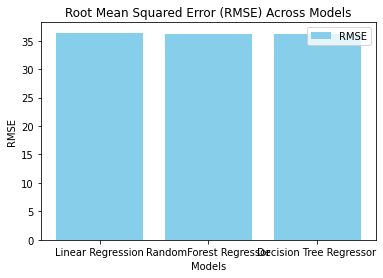

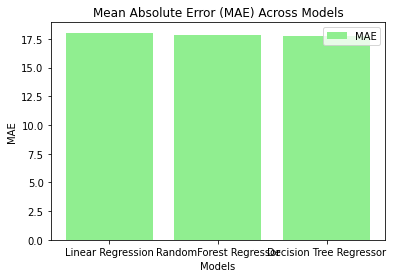

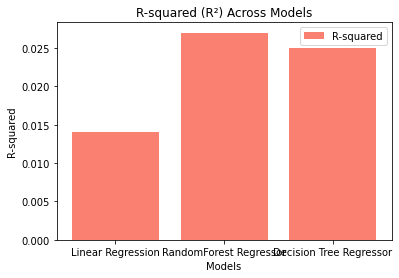

In [0]:
import matplotlib.pyplot as plt

models = ["Linear Regression", "RandomForest Regressor", "Decision Tree Regressor"]
rmse_values = [36.41, 36.17, 36.21]  
mae_values = [18.04, 17.83, 17.78]  
r2_values = [0.014, 0.027, 0.025]    

# Plotting RMSE
plt.bar(models, rmse_values, color='skyblue', label='RMSE')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE) Across Models')
plt.legend()
plt.show()

# Plotting MAE
plt.bar(models, mae_values, color='lightgreen', label='MAE')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) Across Models')
plt.legend()
plt.show()

# Plotting R-squared
plt.bar(models, r2_values, color='salmon', label='R-squared')
plt.xlabel('Models')
plt.ylabel('R-squared')
plt.title('R-squared (R²) Across Models')
plt.legend()
plt.show()


Here We have compared the root mean square error, Mean Absolute Error and R-squared Across all three models 
we can see that:-

Root Mean Squared Error (RMSE):
The RMSE plot shows that all three models have relatively similar RMSE values around 36. Lower RMSE values indicate better model performance, so based on this metric alone, the random forest performs slightly better.

Mean Absolute Error (MAE):
The MAE plot shows that all three models have similar MAE values around 17.5. Like RMSE, lower MAE values are better, and here decision tree performs slightly better.

R-squared (R^2):
The R^2 plot shows the R-squared values for the models. R-squared ranges from 0 to 1, with higher values indicating better model fit. In this case, the random forest Regressor model has the highest R^2 value, around 0.026, followed by the Decision Tree Regressor and Linear regression models.